# List 5 of Machine Learning course

## Introduction

This notebook is part of the Machine Learning course and focuses on the analysis and modeling of the Credit Approval dataset from the UCI Machine Learning Repository. The dataset contains information about credit card applications, with attributes and values anonymized to protect confidentiality.

**Objectives:**

1. **Data Loading and Preprocessing**: Load the dataset, handle missing values, and preprocess the data for modeling.
2. **Exploratory Data Analysis (EDA)**: Perform EDA to understand the data distribution, identify outliers, and derive insights.
3. **Feature Engineering**: Encode categorical variables, scale numerical features, and handle outliers.
4. **Model Training and Evaluation**: Train multiple machine learning models including Random Forest, Histogram-based Gradient Boosting, XGBoost, LightGBM, and CatBoost. Evaluate their performance using cross-validation and various metrics.
5. **Hyperparameter Optimization**: Optimize the hyperparameters of the Random Forest model using Bayesian optimization with Optuna.
6. **Advanced Techniques**: Implement monotonicity constraints and interaction constraints in the Histogram-based Gradient Boosting model to improve performance.

**Dataset:** [Credit Approval](*https://archive.ics.uci.edu/dataset/27/credit+approval*)

This data concerns credit card applications.  All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data.

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sweetviz as sv

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer, precision_score, \
                            recall_score, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna

from ucimlrepo import fetch_ucirepo

d:\Anaconda\envs\PGM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Loading

## Train test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
y_train = y_train.iloc[:, 0].map({'-': 0, '+': 1})
y_test = y_test.iloc[:, 0].map({'-': 0, '+': 1})

## Auto EDA

In [5]:
df_train = pd.concat([X_train, y_train], axis=1)

In [6]:
report = False
if report:
    sweet_report = sv.analyze(df_train, target_feat='A16')
    sweet_report.show_html('credit_approval_EDA.html')

### Conclusions

The original data has 15 features and 690 records. 6 features are continuous and 9 categorical (plus a categorical target). The data has missing values. Target has two classes 0 and 1.

EDA conclusions:
- the class is relatively balanced with a predominance of 0,
- some of the numerical data have outliers such as A15, it was decided that these represent about 0.5% of the data
- 7 features have missing data including 5 categorical and 2 continuous,
- it was decided to replace the continuous variables by the median, as their centre of gravity is more often closer to zero,
- it was decided to replace the categorical variables by the ‘empty’ category,
- because the categorical variables have categories specified in the documentation, it was decided to encode them with CustomEncoder,
- the data show a strong positive correlation between variable A15 and variables A4 and A5, as well as between variables A4 and A5

**It is quite likely that the removal of characteristic A4 or A5 will be lossless, therefore it was decided to remove characteristic A5**.

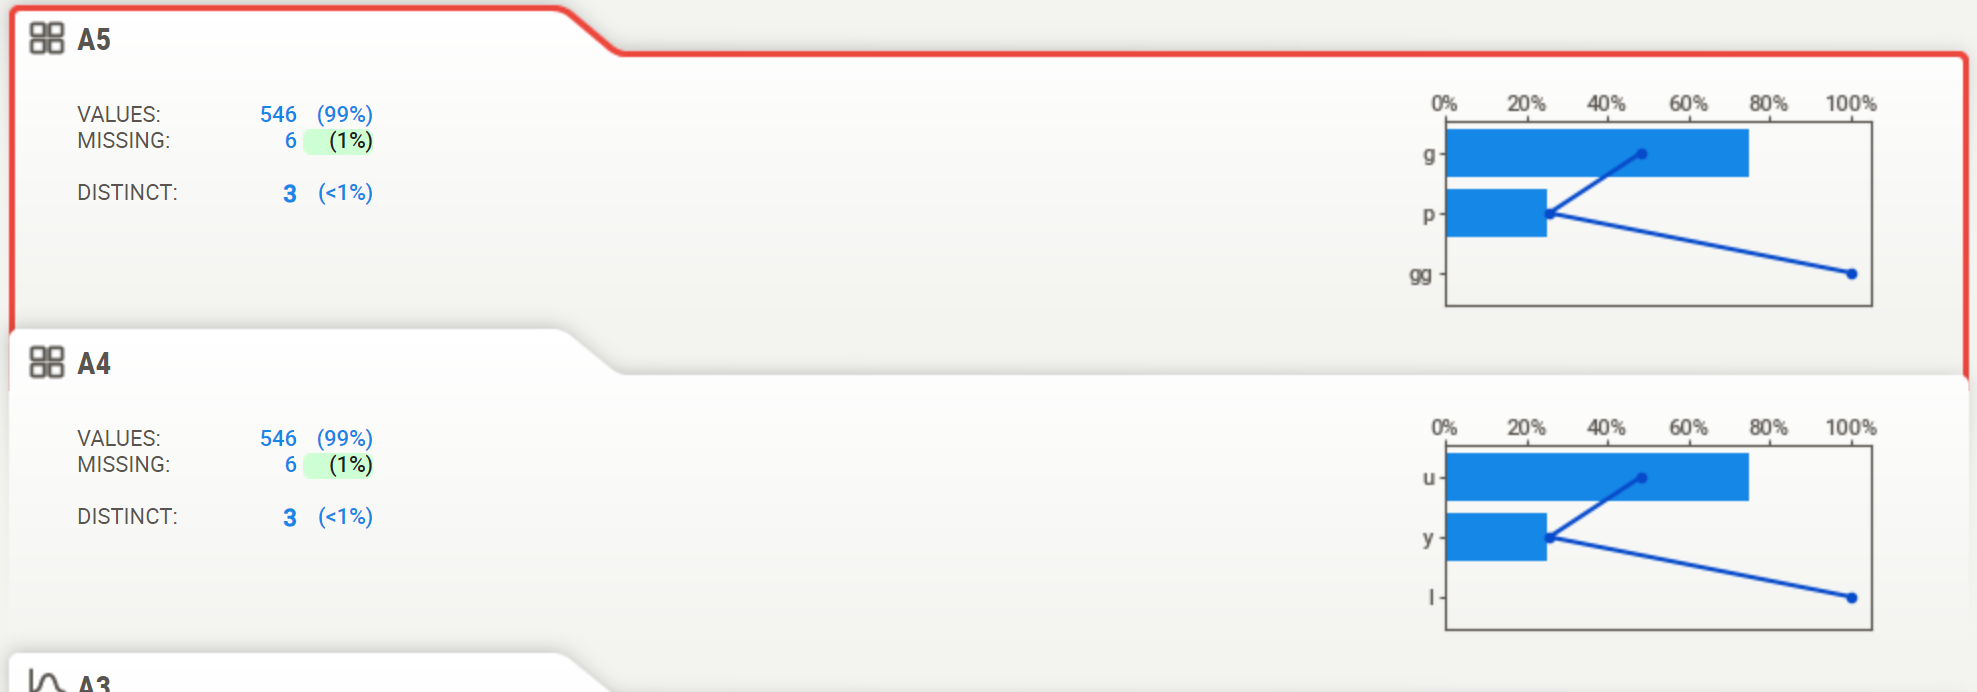

## Utility Classes and Functions

In [7]:
def replace_nans(df_train, df_test):
    for col in df_train.columns:
        if df_train[col].dtype == 'object':
            df_train.loc[:, col] = df_train[col].fillna('nan')
            df_test.loc[:, col] = df_test[col].fillna('nan')
        else:
            df_train.loc[:, col] = df_train[col].fillna(df_train[col].median())
            df_test.loc[:, col] = df_test[col].fillna(df_train[col].median())
    return df_train, df_test

In [8]:
class CustomEncoder(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.encoding_dict = {}

    def fit(self, X, y=None):
        for column in X.columns:
            unique_values = X[column].unique()
            self.encoding_dict[column] = {value: i for i, value in enumerate(unique_values)}
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in X.columns:
            X_transformed[column] = X[column].map(self.encoding_dict[column])
        return X_transformed
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

## Data preparation

Although these alogorithms theoretically handle missing values, their implementations such as **Random Forest** in `sklearn` do not. Additionally, handling missing values can improve the results.

The same applies to normalisation, which is not required for these algorithms, but which can help. As these are tree algorithms, it was decided to use normalisation.

In [9]:
X_train_clean = X_train.drop(columns=['A5'])
X_test_clean = X_test.drop(columns=['A5'])

In [10]:
X_train_clean, X_test_clean = replace_nans(X_train_clean, X_test_clean)

In [11]:
encoder = CustomEncoder()
X_train_clean = encoder.fit_transform(X_train_clean)
X_test_clean = encoder.transform(X_test_clean)

In [12]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

X_train_clean = pd.DataFrame(X_train_scaled, columns=X_train_clean.columns)
X_test_clean = pd.DataFrame(X_test_scaled, columns=X_test_clean.columns)

In [13]:
isf = IsolationForest(contamination=0.005, random_state=42)
isf.fit(X_train_clean)
outliers = isf.predict(X_train_clean)
X_train_clean = X_train_clean[outliers == 1]
y_train_clean = y_train[outliers == 1]

In [14]:
display(X_train_clean.head())
display(y_train_clean.head())
print(f"Cleaned: {X_train_clean.shape}, Original shape: {X_train.shape}")

,A15,A14,A13,A12,A11,A10,A9,A8,A7,A6,A4,A3,A2,A1
0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,0.007092,0.0,1.0,0.05,1.0,1.0,0.008621,0.111111,0.071429,0.333333,0.005348,0.003236,0.0
2,0.0,0.014184,0.5,0.0,0.00,0.0,1.0,0.017241,0.111111,0.142857,0.333333,0.010695,0.006472,0.0
3,0.0,0.021277,0.0,1.0,0.00,0.0,1.0,0.025862,0.111111,0.214286,0.333333,0.016043,0.009709,0.0
4,0.0,0.028369,0.0,0.0,0.10,1.0,1.0,0.034483,0.111111,0.285714,0.333333,0.021390,0.012945,0.0


278    0
110    0
82     0
51     1
218    1
Name: A16, dtype: int64

Cleaned: (549, 14), Original shape: (552, 15)


3 outliers were removed.

## Basic models

In [15]:
results = {}
cv_results = {}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'mcc': make_scorer(matthews_corrcoef)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


### Random Forest

In [16]:
rfc = RandomForestClassifier(random_state=42)

scores = cross_validate(rfc, X_train_clean, y_train_clean, cv=cv, scoring=scoring)

mean_scores = {}
for metric, value in scores.items():
    if 'time' not in metric:
	    mean_scores[f"{metric}_mean"] = round(np.mean(value), 3)

cv_results['RandomForest'] = mean_scores

rfc.fit(X_train_clean, y_train_clean)
y_pred = rfc.predict(X_test_clean)

results['RandomForest'] = {
    'accuracy': round(accuracy_score(y_test, y_pred), 3),
    'precision': round(precision_score(y_test, y_pred), 3),
    'recall': round(recall_score(y_test, y_pred), 3),
    'f1': round(f1_score(y_test, y_pred), 3),
    'mcc': round(matthews_corrcoef(y_test, y_pred), 3),
}

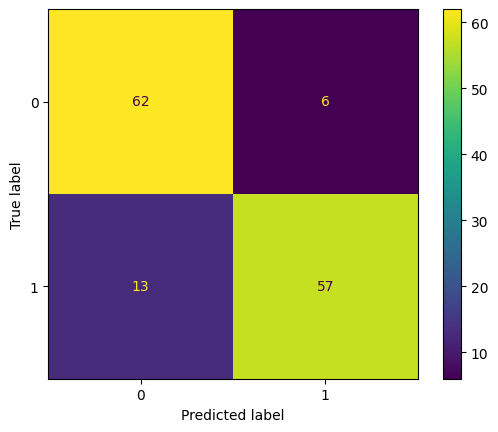

In [17]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

### Histogram-base Gradient Boosting

In [18]:
hgb = HistGradientBoostingClassifier(random_state=42)

scores = cross_validate(hgb, X_train_clean, y_train_clean, cv=cv, scoring=scoring)

mean_scores = {}
for metric, value in scores.items():
    if 'time' not in metric:
	    mean_scores[f"{metric}_mean"] = round(np.mean(value), 3)

cv_results['HistGradientBoosting'] = mean_scores

hgb.fit(X_train_clean, y_train_clean)
y_pred = hgb.predict(X_test_clean)

results['HistGradientBoosting'] = {
    'accuracy': round(accuracy_score(y_test, y_pred), 3),
    'precision': round(precision_score(y_test, y_pred), 3),
    'recall': round(recall_score(y_test, y_pred), 3),
    'f1': round(f1_score(y_test, y_pred), 3),
    'mcc': round(matthews_corrcoef(y_test, y_pred), 3),
}

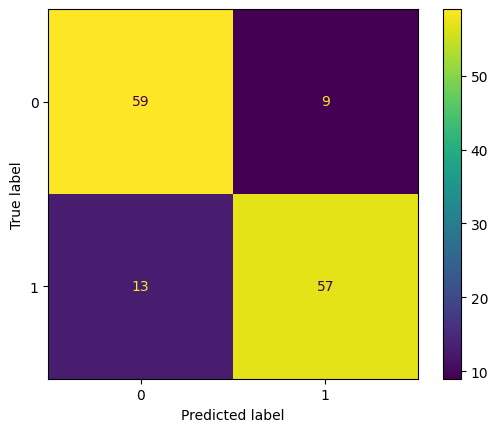

In [19]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

### XGBoost

In [20]:
xgb = XGBClassifier(random_state=42)

scores = cross_validate(xgb, X_train_clean, y_train_clean, cv=cv, scoring=scoring)

mean_scores = {}
for metric, value in scores.items():
    if 'time' not in metric:
	    mean_scores[f"{metric}_mean"] = round(np.mean(value), 3)

cv_results['XGBoost'] = mean_scores

xgb.fit(X_train_clean, y_train_clean)
y_pred = xgb.predict(X_test_clean)

results['XGBoost'] = {
    'accuracy': round(accuracy_score(y_test, y_pred), 3),
    'precision': round(precision_score(y_test, y_pred), 3),
    'recall': round(recall_score(y_test, y_pred), 3),
    'f1': round(f1_score(y_test, y_pred), 3),
    'mcc': round(matthews_corrcoef(y_test, y_pred), 3),
}


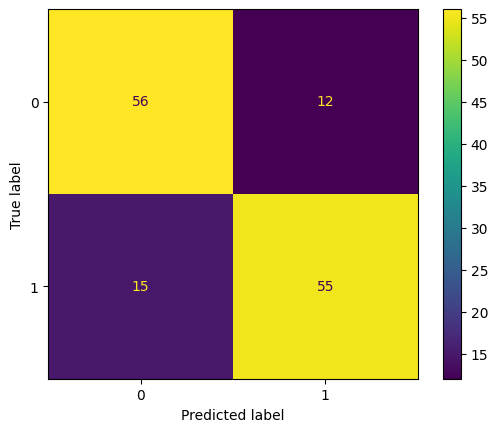

In [21]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

### LightGBM

In [22]:
lgbm = LGBMClassifier(random_state=42)

scores = cross_validate(lgbm, X_train_clean, y_train_clean, cv=cv, scoring=scoring)

mean_scores = {}
for metric, value in scores.items():
    if 'time' not in metric:
        mean_scores[f"{metric}_mean"] = round(np.mean(value), 3)

cv_results['LightGBM'] = mean_scores

lgbm.fit(X_train_clean, y_train_clean)
y_pred = lgbm.predict(X_test_clean)

results['LightGBM'] = {
    'accuracy': round(accuracy_score(y_test, y_pred), 3),
    'precision': round(precision_score(y_test, y_pred), 3),
    'recall': round(recall_score(y_test, y_pred), 3),
    'f1': round(f1_score(y_test, y_pred), 3),
    'mcc': round(matthews_corrcoef(y_test, y_pred), 3),
}


[LightGBM] [Info] Number of positive: 188, number of negative: 251
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 439, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428246 -> initscore=-0.289011
[LightGBM] [Info] Start training from score -0.289011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

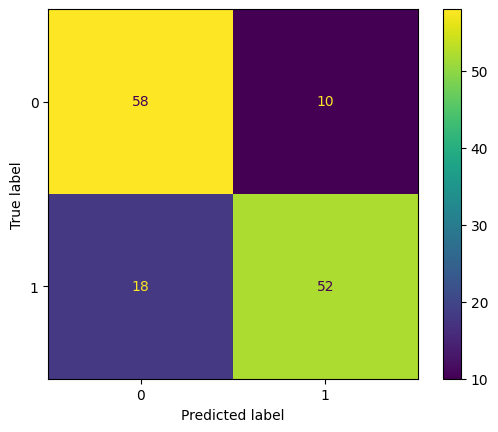

In [23]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

### CatBoost

In [24]:
cat = CatBoostClassifier(random_state=42, verbose=0)

scores = cross_validate(cat, X_train_clean, y_train_clean, cv=cv, scoring=scoring)

mean_scores = {}
for metric, value in scores.items():
    if 'time' not in metric:
        mean_scores[f"{metric}_mean"] = round(np.mean(value), 3)

cv_results['CatBoost'] = mean_scores

cat.fit(X_train_clean, y_train_clean)
y_pred = cat.predict(X_test_clean)

results['CatBoost'] = {
    'accuracy': round(accuracy_score(y_test, y_pred), 3),
    'precision': round(precision_score(y_test, y_pred), 3),
    'recall': round(recall_score(y_test, y_pred), 3),
    'f1': round(f1_score(y_test, y_pred), 3),
    'mcc': round(matthews_corrcoef(y_test, y_pred), 3),
}


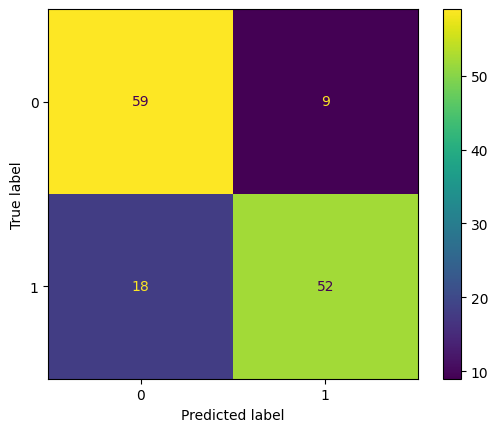

In [25]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

### Results

In [26]:
display(pd.DataFrame(results).T.sort_values(by='mcc', ascending=False))

,accuracy,precision,recall,f1,mcc
RandomForest,0.862,0.905,0.814,0.857,0.729
HistGradientBoosting,0.841,0.864,0.814,0.838,0.683
CatBoost,0.804,0.852,0.743,0.794,0.615
XGBoost,0.804,0.821,0.786,0.803,0.609
LightGBM,0.797,0.839,0.743,0.788,0.599


In [27]:
display(pd.DataFrame(cv_results).T.sort_values(by='test_mcc_mean', ascending=False))

,test_accuracy_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_mcc_mean
RandomForest,0.874,0.877,0.874,0.875,0.747
XGBoost,0.863,0.868,0.863,0.864,0.726
CatBoost,0.860,0.866,0.860,0.860,0.721
LightGBM,0.858,0.862,0.858,0.858,0.715
HistGradientBoosting,0.856,0.860,0.856,0.856,0.711


## RandomForest - parameter optimisation

**Bayesian optimisation** works by continuously updating the probability distribution of parameters based on new data and observations. However, it is complex and computationally expensive.

In [31]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    }
    
    rfc = RandomForestClassifier(random_state=42, **params)
    
    scores = cross_validate(rfc, X_train_clean, y_train_clean, cv=cv, scoring=scoring)
    
    mcc = np.mean(scores['test_mcc'])
    
    return mcc

**Sampler:** *The TPE sampler is a type of Bayesian optimization algorithm that uses past trial information to suggest the hyperparameters for the next trial. It constructs a probabilistic model based on the past trials and samples new hyperparameters from the model.*

In [32]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2024-06-05 19:42:54,297] A new study created in memory with name: no-name-3cd0515a-9b2c-4cf9-a0e6-5cbc50d326ac
[I 2024-06-05 19:43:08,434] Trial 4 finished with value: 0.7197646203580923 and parameters: {'n_estimators': 202, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 4 with value: 0.7197646203580923.
[I 2024-06-05 19:43:14,662] Trial 7 finished with value: 0.7315472145410209 and parameters: {'n_estimators': 356, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 7 with value: 0.7315472145410209.
[I 2024-06-05 19:43:32,548] Trial 1 finished with value: 0.7379573378653331 and parameters: {'n_estimators': 592, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 1 with value: 0.7379573378653331.
[I 2024-06-05 19:43:36,024] Trial 2 finished with value: 0.7142465468747

In [33]:
print(f"Best trial: {study.best_trial.params} with MCC: {study.best_trial.value}")

Best trial: {'n_estimators': 456, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2', 'criterion': 'gini'} with MCC: 0.7534564604221934


In [34]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [35]:
optuna.visualization.plot_parallel_coordinate(study)

In [36]:
optuna.visualization.plot_param_importances(study)

In [37]:
optuna.visualization.plot_slice(study)

## Functionality for HistGradientBoostingClassifier

### Monotonicity constraint

In [39]:
monotonic_constraints_results = {}

In [45]:
monotonicity_constraint1 = {
    'A15': 0,
    'A14': 0,
    'A13': 0,
    'A12': 0,
    'A11': 1,
    'A10': 0,
    'A9': 1,
    'A8': 1,
    'A7': 0,
    'A6': 0,
    'A4': 0,
    'A3': 0,
    'A2': 0,
    'A1': 0,
}  # According to the EDA

monotonicity_constraint2 = {
    'A15': 0,
    'A14': 0,
    'A13': 0,
    'A12': 0,
    'A11': 1,
    'A10': 0,
    'A9': 1,
    'A8': 0,
    'A7': 0,
    'A6': 0,
    'A4': 0,
    'A3': 0,
    'A2': 0,
    'A1': 0,
}

monotonicity_constraint3 = {
    'A15': 0,
    'A14': 0,
    'A13': 0,
    'A12': 0,
    'A11': 1,
    'A10': 0,
    'A9': 1,
    'A8': 0,
    'A7': 0,
    'A6': 0,
    'A4': 0,
    'A3': 1,
    'A2': 1,
    'A1': 0,
}

monotonicity_constraint4 = {
    'A15': 0,
    'A14': 0,
    'A13': 0,
    'A12': 0,
    'A11': -1,
    'A10': 0,
    'A9': -1,
    'A8': 0,
    'A7': 0,
    'A6': 0,
    'A4': 0,
    'A3': 0,
    'A2': 0,
    'A1': 0,
} # reverse EDA

monotonicity_constraints = {
    "EDA>0.4": monotonicity_constraint1,
    "EDA>0.3": monotonicity_constraint2,
    "EDA>0.2": monotonicity_constraint3,
    "Reverse_EDA": monotonicity_constraint4,
    "0": {col: 0 for col in X_train_clean.columns},
    "-1": {col: -1 for col in X_train_clean.columns},
    "1": {col: 1 for col in X_train_clean.columns},
}

In [46]:
for name, mc in monotonicity_constraints.items():
    hgb = HistGradientBoostingClassifier(random_state=42, monotonic_cst=mc)

    scores = cross_validate(hgb, X_train_clean, y_train_clean, cv=cv, scoring=scoring)

    mean_scores = {}
    for metric, value in scores.items():
        if 'time' not in metric:
            mean_scores[f"{metric}".replace('test_', '')] = round(np.mean(value), 3)
    
    monotonic_constraints_results[name] = mean_scores


In [48]:
mon_cst_results_df = pd.DataFrame(monotonic_constraints_results).T.sort_values(by='mcc', ascending=False)
display(mon_cst_results_df)

,accuracy,precision,recall,f1,mcc
EDA>0.3,0.872,0.875,0.872,0.872,0.743
EDA>0.2,0.871,0.874,0.871,0.871,0.740
1,0.862,0.865,0.862,0.861,0.721
EDA>0.4,0.860,0.862,0.860,0.860,0.717
0,0.856,0.860,0.856,0.856,0.711
Reverse_EDA,0.739,0.743,0.739,0.737,0.470
-1,0.545,0.516,0.545,0.497,0.009


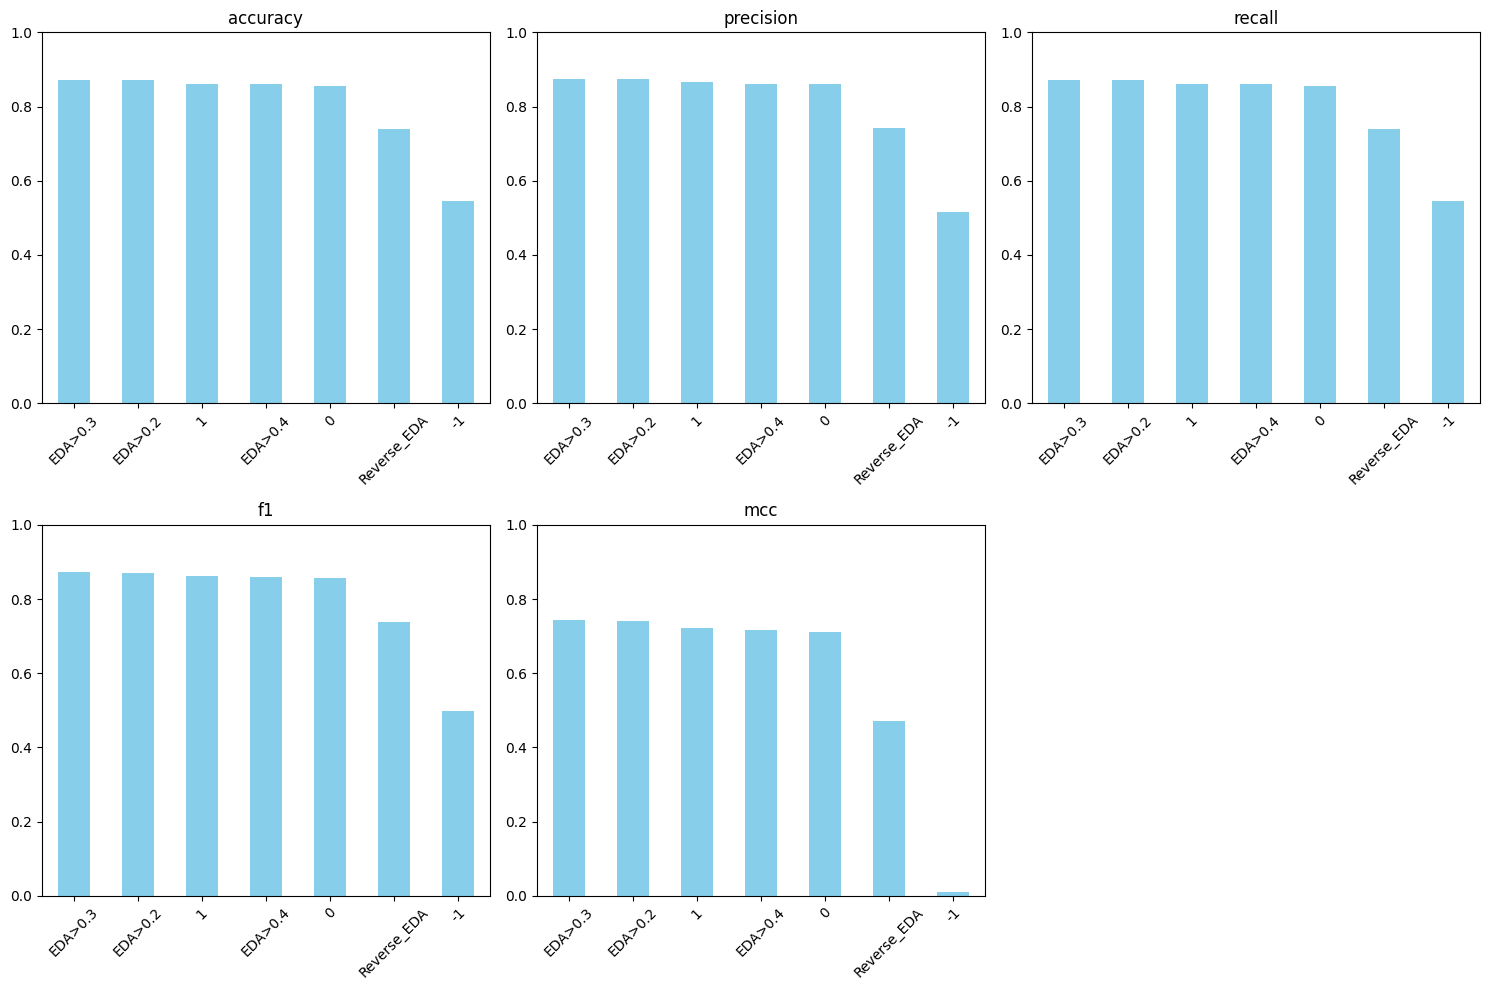

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, metric in enumerate(mon_cst_results_df.columns):
    row = i // 3
    col = i % 3
    mon_cst_results_df[metric].plot(kind='bar', color='skyblue', ax=axs[row, col])
    axs[row, col].set_title(metric)
    axs[row, col].set_ylim(0, 1)
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45)

# Remove the empty subplot (if any)
if len(mon_cst_results_df.columns) < 6:
    fig.delaxes(axs.flatten()[len(mon_cst_results_df.columns)])

plt.tight_layout()
plt.show()

### Interaction Constraint

In [56]:
def suggest_interactions(df, threshold=0.7):
    corr_matrix = df.corr()
    interactions = []

    for i in range(corr_matrix.shape[0]):
        for j in range(i+1, corr_matrix.shape[1]):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                interactions.append([i, j])

    return interactions

In [57]:
interaction_cst = {"pairwise": "pairwise", "no_interactions": "no_interactions"}

for i in range(1, 10):
    interactions = suggest_interactions(X_train_clean, i/10)
    interaction_cst[f"threshold_{i/10}"] = interactions

interaction_cst_results = {}


In [58]:
for name, ic in interaction_cst.items():
    hgb = HistGradientBoostingClassifier(random_state=42, interaction_cst=ic)

    scores = cross_validate(hgb, X_train_clean, y_train_clean, cv=cv, scoring=scoring)

    mean_scores = {}
    for metric, value in scores.items():
        if 'time' not in metric:
            mean_scores[f"{metric}".replace('test_', '')] = round(np.mean(value), 3)
    
    interaction_cst_results[name] = mean_scores

In [59]:
int_cst_results_df = pd.DataFrame(interaction_cst_results).T.sort_values(by='mcc', ascending=False)
display(int_cst_results_df)

,accuracy,precision,recall,f1,mcc
threshold_0.1,0.876,0.879,0.876,0.876,0.750
pairwise,0.871,0.873,0.871,0.871,0.739
threshold_0.4,0.871,0.874,0.871,0.870,0.739
no_interactions,0.869,0.872,0.869,0.869,0.736
threshold_0.2,0.867,0.869,0.867,0.867,0.731
threshold_0.5,0.865,0.869,0.865,0.865,0.730
threshold_0.6,0.865,0.869,0.865,0.865,0.730
threshold_0.7,0.865,0.869,0.865,0.865,0.730
threshold_0.3,0.865,0.868,0.865,0.865,0.728
threshold_0.8,0.856,0.860,0.856,0.856,0.711


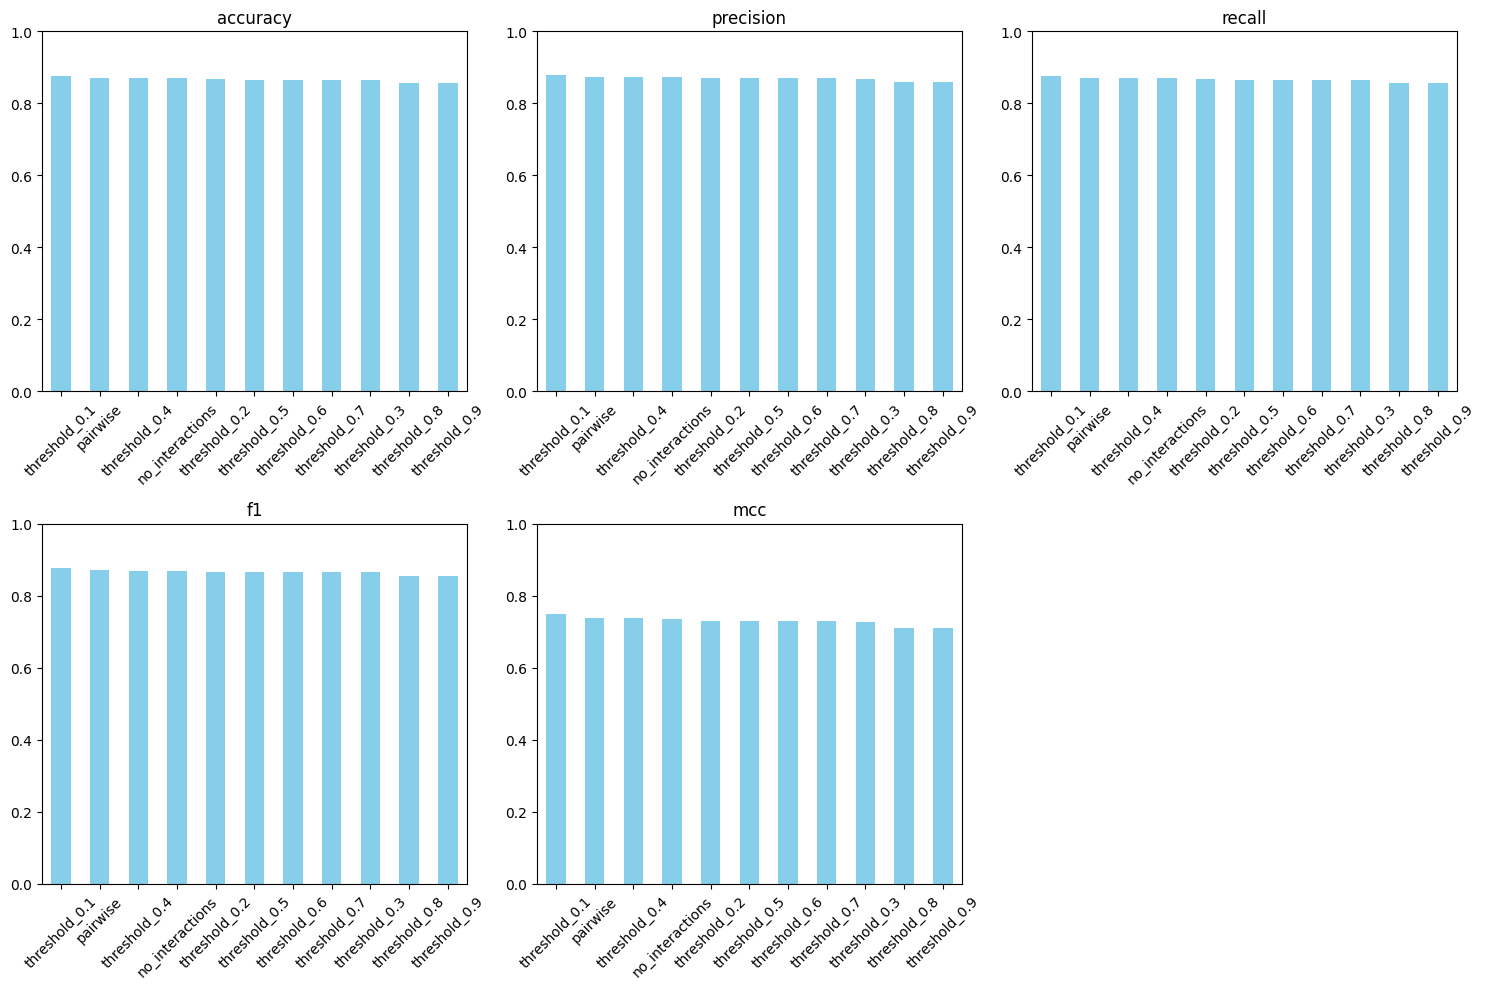

In [60]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, metric in enumerate(int_cst_results_df):
    row = i // 3
    col = i % 3
    int_cst_results_df[metric].plot(kind='bar', color='skyblue', ax=axs[row, col])
    axs[row, col].set_title(metric)
    axs[row, col].set_ylim(0, 1)
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45)

if len(int_cst_results_df.columns) < 6:
    fig.delaxes(axs.flatten()[len(int_cst_results_df.columns)])

plt.tight_layout()
plt.show()

### Combination of restrictions

In [61]:
both_cst_results = {}

In [62]:
for name_ic, ic in interaction_cst.items():
    for name_mc, mc in monotonicity_constraints.items():
        hgb = HistGradientBoostingClassifier(random_state=42, interaction_cst=ic, monotonic_cst=mc)

        scores = cross_validate(hgb, X_train_clean, y_train_clean, cv=cv, scoring=scoring)

        mean_scores = {}
        for metric, value in scores.items():
            if 'time' not in metric:
                mean_scores[f"{metric}".replace('test_', '')] = round(np.mean(value), 3)
        
        both_cst_results[name_ic + "_" + name_mc] = mean_scores

In [63]:
both_cst_df = pd.DataFrame(both_cst_results).T.sort_values(by='mcc', ascending=False)
display(both_cst_df)

,accuracy,precision,recall,f1,mcc
no_interactions_EDA>0.4,0.878,0.882,0.878,0.878,0.756
threshold_0.7_EDA>0.3,0.878,0.881,0.878,0.878,0.755
threshold_0.5_EDA>0.3,0.878,0.881,0.878,0.878,0.755
threshold_0.6_EDA>0.3,0.878,0.881,0.878,0.878,0.755
threshold_0.2_EDA>0.2,0.876,0.879,0.876,0.876,0.750
...,...,...,...,...,...
threshold_0.7_-1,0.545,0.516,0.545,0.497,0.009
no_interactions_-1,0.548,0.524,0.548,0.472,0.002
threshold_0.3_-1,0.550,0.502,0.550,0.462,-0.016
threshold_0.2_-1,0.541,0.505,0.541,0.464,-0.022


### Conclusions on constraints

They have quite an impact and can nicely increase the model results if we have apriori knowledge. But we can easily and badly mess up the model if we set them wrong.

A good thing to set them is correlation, so it is worth taking them into account when tuning the model.